In [314]:
from __future__ import print_function, division

In [315]:
# import libraries
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import scale, PolynomialFeatures
from sklearn.svm import SVR
from sklearn.decomposition import KernelPCA
from sklearn.linear_model import Ridge, ElasticNet, BayesianRidge, Lasso
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [316]:
# update your data path
DATA_PATH = "/home/aunagar/Personal/Study/Sem1/Advanced ML/projects/task1/Task1/"

In [317]:
# import data
train_X = pd.read_csv(DATA_PATH + "X_train.csv")
train_Y = pd.read_csv(DATA_PATH + "y_train.csv")
test_X = pd.read_csv(DATA_PATH + "X_test.csv")
sample_submission = pd.read_csv(DATA_PATH + "sample.csv")

In [318]:
# split data
train_ids = train_X.iloc[:, 0]
train_features = train_X.iloc[:, 1:]
test_ids = test_X.iloc[:, 0]
test_features = test_X.iloc[:, 1:]

In [319]:
######## missing value imputation########
# train
train_features = train_features.fillna(train_features.mean())
# test
test_features = test_features.fillna(train_features.mean())


####### limiting feature using variance threshold (i.e. remove features with 0 variance) ######
train_features_mean, train_features_std = train_features.mean(), train_features.std()

train_features = train_features.iloc[:, np.where(train_features_std > 0.0)[0]]
test_features = test_features.iloc[:, np.where(train_features_std > 0.0)[0]]

############## Outlier removal ###############
train_features_mean, train_features_std = train_features.mean(), train_features.std()
# train
train_features[train_features > train_features_mean + 2*train_features_std] = np.nan
train_features[train_features < train_features_mean -2*train_features_std] = np.nan
train_features = train_features.fillna(train_features.mean())

# test
test_features[test_features > train_features_mean + 2*train_features_std] = np.nan
test_features[test_features < train_features_mean - 2*train_features_std] = np.nan
test_features = test_features.fillna(train_features.mean())

In [320]:
##### Normalization #####
# train
train_mean, train_std = train_features.mean(), train_features.std()
train_features = (train_features - train_mean)/train_std
# test 
test_features = (test_features - train_mean)/train_std

In [321]:
###### Correlated feature removal #########
# Create correlation matrix
corr_matrix = train_features.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.7
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

# train
train_features = train_features.drop(columns = to_drop)
# test
test_features = test_features.drop(columns = to_drop)

In [322]:
###### linear model
lr = ElasticNet(alpha = 0.5, l1_ratio=0.5)
#lr = Lasso(alpha = 0.25, max_iter = 10000)
validation_score = cross_val_score(lr, train_features, train_Y.iloc[:, 1:], cv = 5, scoring = 'r2')
print(validation_score.mean())

# train model on whole train data
lr.fit(X = train_features, y = train_Y.iloc[:, 1])

0.4853832911915085


ElasticNet(alpha=0.5, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [323]:
# finding to which features to remove
non_zero_weights = np.where(lr.coef_ != 0.)[0]

# removing these features from training data
train_features = train_features.iloc[:, non_zero_weights]
test_features = test_features.iloc[:, non_zero_weights]

In [324]:
###### linear model
alpha = np.arange(0.1, 2, 0.2)
l1_ratio = np.arange(0.1, 1, 0.2)
results = pd.DataFrame(columns=['alpha', 'l1_ratio', 'cv_score'])
for a in alpha:
    for l1 in l1_ratio:
        lr = ElasticNet(alpha = a, l1_ratio=l1)
        validation_score = cross_val_score(lr, train_features, train_Y.iloc[:, 1:], cv = 5, scoring = 'r2')
        results = results.append({'alpha':a, 'l1_ratio':l1, 'cv_score':validation_score.mean()}, ignore_index = True)

best_parameters = results.iloc[np.argmax(results.cv_score.values),:]
print(best_parameters['cv_score'])

# train model on whole train data
lr = ElasticNet(alpha = best_parameters['alpha'], l1_ratio = best_parameters['l1_ratio'])
lr.fit(X = train_features, y = train_Y.iloc[:, 1])

0.5745746898858496


ElasticNet(alpha=0.30000000000000004, copy_X=True, fit_intercept=True,
           l1_ratio=0.1, max_iter=1000, normalize=False, positive=False,
           precompute=False, random_state=None, selection='cyclic', tol=0.0001,
           warm_start=False)

In [325]:
# training support vector regression
svr = SVR(kernel = 'rbf', degree = 10, gamma = 'scale', C = 4)
validation_score = cross_val_score(svr, train_features, train_Y.iloc[:, 1], cv = 5, scoring = 'r2')
print(validation_score.mean())

svr.fit(train_features, y = train_Y.iloc[:, 1].values)

0.5512171787243063


SVR(C=4, cache_size=200, coef0=0.0, degree=10, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [ ]:
#### training more complex model on this cleared data
rfr = RandomForestRegressor(n_estimators=1000, max_depth=15, verbose = True, n_jobs = -1)
validation_score = cross_val_score(rfr, train_features, train_Y.iloc[:, 1], cv = 5, scoring= 'r2')
print(validation_score.mean())

rfr.fit(X= train_features, y = train_Y.iloc[:, 1].values)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   41.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.6s


### Model diagnostics

In [299]:
X_train, X_val, Y_train, Y_val = train_test_split(train_features, train_Y.iloc[:, 1], test_size = 0.33, shuffle = True)

In [312]:
# select model to diagnose
lr = SVR(kernel='rbf', C = 4)
lr.fit(X_train, Y_train)
train_predicted = lr.predict(X_train)
val_predicted = lr.predict(X_val)
training_r2_score = r2_score(Y_train.values, train_predicted)
validation_r2_score = r2_score(Y_val.values, val_predicted)

/home/aunagar/miniconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [313]:
print(training_r2_score)
print(validation_r2_score)

0.7695852122684048
0.5239730173199126


In [306]:
Y_val

749     61.0
113     62.0
1029    72.0
153     70.0
417     77.0
        ... 
948     55.0
894     87.0
1031    68.0
1174    70.0
376     64.0
Name: y, Length: 400, dtype: float64

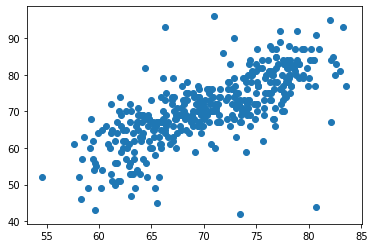

In [309]:
plt.scatter(lr.predict(X_val), Y_val)
plt.show()

In [301]:
from sklearn.metrics import r2_score

rfr_r2 = r2_score(rfr.predict(train_features), train_Y.iloc[:, 1])
lr_r2 = r2_score(lr.predict(train_features), train_Y.iloc[:, 1])
svr_r2 = r2_score(svr.predict(train_features), train_Y.iloc[:, 1])

print('rfr score: ', rfr_r2, '\n')
print('svr score: ', svr_r2, '\n')
print('lr score: ', lr_r2, '\n')

ValueError: Number of features of the model must match the input. Model n_features is 157 and input n_features is 168 

### Make Predictions

In [130]:
best_model = svr

In [131]:
predicted = best_model.predict(test_features)
sample_submission['y'] = predicted

In [132]:
sample_submission.to_csv("submissions/Ajay_8th_sub.csv", index = False)